# Imports

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Open Datasets

In [3]:
def get_all_data():
    root = "Datasets/"

    with open(root + "imdb_labelled.txt", "r") as text_file:
        data = text_file.read().split('\n')
         
    with open(root + "amazon_cells_labelled.txt", "r") as text_file:
        data += text_file.read().split('\n')

    with open(root + "yelp_labelled.txt", "r") as text_file:
        data += text_file.read().split('\n')

    return data

values = get_all_data()
print(values[0])
print(values[10])
print(values[100])
print(values[1000])

A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  	0
And those baby owls were adorable.  	1
I don't think you will be disappointed.  	1
So there is no way for me to plug it in here in the US unless I go by a converter.	0


## Preprocessing of data

In [4]:
def preprocessing_data(data):
    processing_data = []
    for single_data in data:
        if len(single_data.split("\t")) == 2 and single_data.split("\t")[1] != "":
            processing_data.append(single_data.split("\t"))

    return processing_data

all_data = get_all_data()
values = preprocessing_data(all_data)
print(values[0])
print(values[10])

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ', '0']
['And those baby owls were adorable.  ', '1']


## Split Data

In [5]:
def split_data(data):
    total = len(data)
    training_ratio = 0.75
    training_data = []
    evaluation_data = []

    for indice in range(0, total):
        if indice < total * training_ratio:
            training_data.append(data[indice])
        else:
            evaluation_data.append(data[indice])

    return training_data, evaluation_data

## Preprocessing Step

In [6]:
def preprocessing_step():
    data = get_all_data()
    processing_data = preprocessing_data(data)

    return split_data(processing_data)

## Training Step

In [7]:
def training_step(data, vectorizer):
    training_text = [data[0] for data in data]
    training_result = [data[1] for data in data]

    training_text = vectorizer.fit_transform(training_text)

    return BernoulliNB().fit(training_text, training_result)

## Score Step

In [8]:
training_data, evaluation_data = preprocessing_step()
vectorizer = CountVectorizer(binary = 'true')
classifier = training_step(training_data, vectorizer)
result = classifier.predict(vectorizer.transform(["I love this movie!"]))

result[0]

'1'

In [9]:
def analyse_text(classifier, vectorizer, text):
    return text, classifier.predict(vectorizer.transform([text]))

new_result = analyse_text(classifier, vectorizer, "Best product ever")
new_result

('Best product ever', array(['1'], dtype='<U1'))

In [10]:
def print_result(result):
    text, analysis_result = result
    print_text = "Positive" if analysis_result[0] == '1' else "Negative"
    print(text, ":", print_text)
    
print_result(new_result)

Best product ever : Positive


### More examples

In [11]:
print_result( analyse_text(classifier, vectorizer,"this is the best movie"))
print_result( analyse_text(classifier, vectorizer,"this is the worst movie"))
print_result( analyse_text(classifier, vectorizer,"awesome!"))
print_result( analyse_text(classifier, vectorizer,"10/10"))
print_result( analyse_text(classifier, vectorizer,"so bad"))
print_result( analyse_text(classifier, vectorizer,"nice"))

this is the best movie : Positive
this is the worst movie : Negative
awesome! : Positive
10/10 : Positive
so bad : Negative
nice : Positive


## Evaluation Step

In [124]:
def simple_evaluation(evaluation_data):
    evaluation_text     = [evaluation_data[0] for evaluation_data in evaluation_data]
    evaluation_result   = [evaluation_data[1] for evaluation_data in evaluation_data]

    total = len(evaluation_text)
    corrects = 0
    for index in range(0, total):
        analysis_result = analyse_text(classifier, vectorizer, evaluation_text[index])
        text, result = analysis_result
        corrects += 1 if result[0] == evaluation_result[index] else 0

    return corrects * 100 / total

simple_evaluation(evaluation_data)

82.0

### Confusion Matrix

In [128]:
def create_confusion_matrix(evaluation_data):
    evaluation_text     = [evaluation_data[0] for evaluation_data in evaluation_data]
    actual_result       = [evaluation_data[1] for evaluation_data in evaluation_data]
    prediction_result   = []
    for text in evaluation_text:
        analysis_result = analyse_text(classifier, vectorizer, text)
        prediction_result.append(analysis_result[1][0])
    
    matrix = confusion_matrix(actual_result, prediction_result)
    return matrix
    
confusion_matrix_result = create_confusion_matrix(evaluation_data)

array([[322,  64],
       [ 71, 293]])

## Data Frame

In [126]:
pandas.DataFrame(confusion_matrix_result, columns=["Negatives", "Positives"],index=["Negatives", "Positives"])

,Negatives,Positives
Negatives,322,64
Positives,71,293


### Plot Confusion Matrix

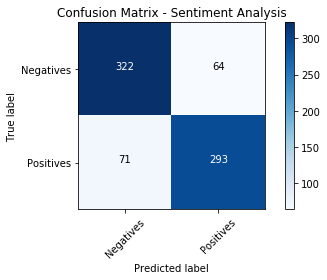

In [127]:
classes = ["Negatives", "Positives"]

plt.figure()
plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

text_format = 'd'
thresh = confusion_matrix_result.max() / 2.
for row, column in itertools.product(range(confusion_matrix_result.shape[0]), range(confusion_matrix_result.shape[1])):
    plt.text(column, row, format(confusion_matrix_result[row, column], text_format),
             horizontalalignment="center",
             color="white" if confusion_matrix_result[row, column] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()

In [29]:
true_negatives = confusion_matrix_result[0][0]
false_negatives = confusion_matrix_result[0][1]
false_positives = confusion_matrix_result[1][0]
true_positives = confusion_matrix_result[1][1]

accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2*(recall * precision) / (recall + precision)

print('Accuracy:',accuracy)
print('Precision:',precision)
print('Recall:',recall)
print('F1 Score:',f1_score)

Accuracy: 0.82
Precision: 0.804945054945055
Recall: 0.8207282913165266
F1 Score: 0.812760055478502
